# References for Understanding the concepts of Neural Network- 
https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839 <br>
https://stackabuse.com/creating-a-neural-network-from-scratch-in-python-multi-class-classification/  <br>
https://medium.com/@udaybhaskarpaila/multilayered-neural-network-from-scratch-using-python-c0719a646855

# Assignment I: CS776A - Deep Learning for Computer Vision
# 


In [1]:
import cv2
import math
import tarfile
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from codefiles import feature_extractor

## 1) - We have to download and load the cifar10 dataset

In [2]:
class load_data():
    def unpickle(self,file):
        '''
        The unpickle function loads data from the input pickle files
        '''
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def load_cifar10(self,filepath):
        '''
        This function loads the CIFAR10 data and returns the following:
            train_data: (50000, 3, 32, 32) numpy array consisting of training images
            train_labels: (50000, 10) numpy array consisting of one_hot_encoded labels
            test_data: (10000, 3, 32, 32) numpy array consisting of test data images
            test_labels: (10000, 10) numpy array consisting of one_hot_encoded labels
        '''
        
        # Extract the tar file
        tar = tarfile.open(filepath, "r:gz")
        tar.extractall()
        tar.close()
        
        # Load the metadata using unpickle
        batches_meta = self.unpickle('cifar-10-batches-py/batches.meta')

        # Extract the label_names from the metadata dictionary
        label_names = batches_meta[b'label_names']

        # Load all the five training batches and test batch using unpickle
        for i in range(1, 6):
            data_batch = self.unpickle('cifar-10-batches-py/data_batch_'+str(i))
            if i==1:
                train_data = np.array(data_batch[b'data'])
                train_labels = np.array(data_batch[b'labels'])
            else:
                train_data = np.vstack((train_data, data_batch[b'data']))
                train_labels = np.concatenate([train_labels, data_batch[b'labels']])
        test_data = self.unpickle('cifar-10-batches-py/test_batch')[b'data']
        test_labels = self.unpickle('cifar-10-batches-py/test_batch')[b'labels']
        
        # Reshape the train and test data
        train_data = train_data.reshape((len(train_data), 3, 32, 32))
        test_data = test_data.reshape((len(test_data), 3, 32, 32))
        train_labels = np.array(train_labels)
        test_labels = np.array(test_labels)
        
        return train_data, train_labels, test_data, test_labels

# Load train and test data of CIFAR10

To run the below cell we should have the cifar file but due to limit on upload on helloiitk portal. We cannot upload the cifar file. So, we are using pickle file to load essential data.

In [47]:
RUN = False  # set it to True if have access to cifar file.
if RUN:
    object = load_data()
    unaugmented_train_data, unaugmented_train_labels, unaugmented_test_data, unaugmented_test_labels = object.load_cifar10('cifar-10-python.tar.gz')
else:
    with open('unaugmented_train_labels.pkl', 'rb') as file:
        unaugmented_train_labels = pickle.load(file)
    with open('unaugmented_test_labels.pkl', 'rb') as file:
        unaugmented_test_labels = pickle.load(file)
    print(unaugmented_train_labels.shape,unaugmented_test_labels.shape)

(50000,) (10000,)


## 2) - We have to implement Stated Transformations

(a) Image_enhancement

In [ ]:
def image_enhancement(img):
    channels, height , width = img.shape[0] , img.shape[1] , img.shape[2]
    for _ in range(channels):
        # getting min and max value of a channel
        mx = img[_].max()
        mn = img[_].min()
        for i in range(height):
            for j in range(width):
                img[_][i][j] = (img[_][i][j] - mn)/(mx-mn) * 255


    return np.transpose(img, (1, 2, 0)) #returning transposed image

(b) Image Posterization

In [5]:
def image_posterization(img):
    mx ,mn = 225 , 3
    r = mx-mn
    divider = 255/r
    channels , height , width = img.shape[0] , img.shape[1] , img.shape[2]
    for i in range(channels):
        for j in range(height):
            for k in range(width):
                img[i][j][k] = img[i][j][k] / divider
                img[i][j][k] = img[i][j][k] + mn
                # checking corner cases
                if img[i][j][k] > 255:
                    img[i][j][k] = 255
                elif img[i][j][k] < 0:
                    img[i][j][k] = 0
    return np.transpose(img,(1,2,0))

(C) Random Rotate

In [6]:
def random_rotate(img):
    img = np.transpose(img, (1, 2, 0)) # transposing so that the channels be at the last
    height, width = img.shape[0], img.shape[1]
    
    # Select a random angle value between -180 to 180 degrees and convert it into radians  
    angle = math.radians(random.randint(-180, 180))  #inner random.randint function will return random values betweem -180 to 180 degrees.
    sin, cos = math.sin(angle), math.cos(angle)
    
    Output_image = np.zeros_like(img) # initialization with zeros
    
    center_coordinate = int(height/2) # Centre pixel
    
    for i in range(height):
        for j in range(width):
            new_location = int(-(height-center_coordinate-j-1)*sin + (height-center_coordinate-i-1)*cos) , int((height-center_coordinate-j-1)*cos + (height-center_coordinate-i-1)*sin)   
            new_location = center_coordinate - new_location[0], center_coordinate - new_location[1]
            
            # Checking if the modified pixel location lies within the range then assign the pixel value from the input image, else leave it as 0
            if 0 <= new_location[0] < height and 0 <= new_location[1] < width and new_location[0] >= 0 and new_location[1] >= 0:
                Output_image[new_location[0], new_location[1], :] = img[i, j, :] 
    return Output_image

(d) Contrast & Horizontal flipping

In [7]:
def contrast_and_horizontal_flip(img):
    

    img = np.transpose(img, (1, 2, 0))
    
    # Select a random alpha in the range [0.5, 2.0]
    alpha = random.uniform(0.5, 2.0)

    # Copy the image to an Output_image variable and convert float values to int
    Output_image = img.copy()
    Output_image = np.float32(Output_image)

    Output_image = alpha*(Output_image-128) + 128
    Output_image[Output_image < 0], Output_image[Output_image > 255] = 0, 255  #Clipping the values
    
    # Horizontal flip with a probability 0.5.
    # Select a random number between 0 and 1, and if the number is 1 then do horizontal flip
    if(random.randint(0, 1) == 1):
        Output_image = Output_image[:, ::-1, :]  # Keep the channels and height same, but flip the width
    
    Output_image = np.uint8(Output_image)
    
    return Output_image

### Testing the Tranformations

## Dont execute the below cell as we dont have access to cifar file it will gonna throw error.

original Image


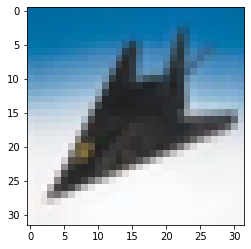

Rotated Image


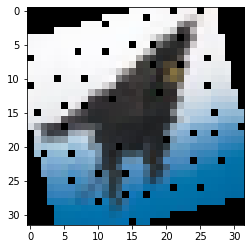

Enhanced_image


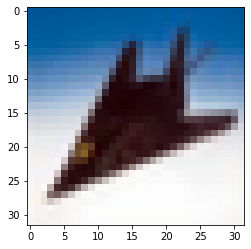

Posterized_image


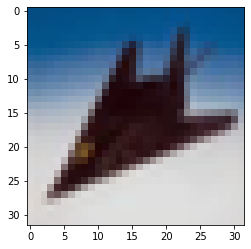

Constrasted and Horizontally Flipped Image


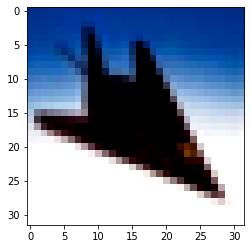

In [44]:
# Test the above transformation functions

pic = unaugmented_train_data[np.random.randint(0, len(unaugmented_train_data))]  #random image

print("original Image")
plt.imshow(np.transpose(pic,(1,2,0)), interpolation='nearest')
plt.show()

print("Rotated Image")
img = random_rotate(pic)
plt.imshow(img, interpolation='nearest')
plt.show()

print("Enhanced_image")
img = image_enhancement(pic)
plt.imshow(img, interpolation='nearest')
plt.show()

print("Posterized_image")
img = image_posterization(pic)
plt.imshow(img, interpolation='nearest')
plt.show()

print("Constrasted and Horizontally Flipped Image")
img = contrast_and_horizontal_flip(pic)
plt.imshow(img, interpolation='nearest')
plt.show()

## 3)- We have to form augmented data by applying above transformations on unaugmented data

In [48]:
def augument_data(unaugmented_train_data):
    '''
    The following function augments the training data with the
    additional transformed images.
    '''
    # We create an array to store the transformed images
    transformed_data = np.zeros((len(unaugmented_train_data), 3, 32, 32))
    
    # Iterate over the images in training data and update our transformed_data array
    for i in range(len(unaugmented_train_data)):
        
        # Choose a random number between 0-3 and apply one of the transformation
        Choose = random.randint(0, 3)
        
        if Choose == 0 :
            Output_image = random_rotate(unaugmented_train_data[i])
        elif Choose == 1:
            Output_image = image_enhancement(unaugmented_train_data[i])
        elif Choose == 2:
            Output_image = image_posterization(unaugmented_train_data[i])
        else:
            Output_image = contrast_and_horizontal_flip(unaugmented_train_data[i])
        
        # Shift image channels to the start so that image shape is now (3, 32, 32)
        Output_image = np.transpose(Output_image, (2, 0, 1))
        
        # Update Output_image tranformed_train_data array with the transformed image
        transformed_data[i] = Output_image
    
    # Append transformed train data to the original train data to make an augmented dataset
    augmented_train_data = np.concatenate([unaugmented_train_data, transformed_data])

    return augmented_train_data

By running the below cell we get our augmented data but it takes about 6 minutes to run .

In [49]:
# Augment the training data with transformed images
Run = False  # set to True to run the cell
if Run:
    augmented_train_data = augument_data(unaugmented_train_data)
    augmented_test_data = augument_data(unaugmented_test_data)

In [50]:
augmented_train_labels = np.concatenate([unaugmented_train_labels, unaugmented_train_labels])
augmented_test_labels  =  np.concatenate([unaugmented_test_labels,unaugmented_test_labels])

# 4)- We have to use Feature extractor file for getting 1-D Features Vectors of unaugmented and augmented data.

Below is the code that we have used for getting the features vectors with instuctions that are asked in the Question. But, here we have set Run = False because it takes too much time to get the Feature Vectors of unaugmented and augmented. Here, we are loading a already featurized file because converting images to Feature Vectors takes a lot of time. Last time we run it and it takes about 2 hrs.

In [57]:
def resize(x):
    '''
    The following function resizes the input image from (32, 32, 3) to (224, 224, 3)
    We use list comprehension to perform the resize operation of all the images in 'x'
    Steps:
        For all images in x:
            1. Transpose the image to shape (32, 32, 3)
            2. Resize the image to (224, 224, 3)
            3. Re-transpose the image to shape (3, 224, 224)
    '''

    resized_x = np.array([np.transpose(cv2.resize(np.transpose(img, (1, 2, 0)), (224, 224)), (2, 0, 1)) for img in x])
    
    return resized_x

def get_features(x, batch_size=100):
    '''
    The following function uses the BBResNet18 object to extract the features.
    Since the data is very large, we pass the data in batches to the feature_extractor.
    '''

    # Calculate number of batches
    batches = int(len(x) / batch_size)

    print('Number of Batches: ', str(batches))
    
    # Create an object of BBResNet18 class
    Object = feature_extractor.BBResNet18()
    
    for i in range(batches):
        
        # Resize the current batch
        batch = x[i*batch_size:(i+1)*batch_size]
        batch = resize(batch)

        # Normalize the values in the batch
        batch /= 255

        # Convert datatype to float
        batch = np.float32(batch)
        
        # Extract features using the feature_extraction function provided in assignment codefiles
        if i == 0:
            features = Object.feature_extraction(batch)
        else:
            features = np.append(features, Object.feature_extraction(batch), axis=0)
        
        print('Processing Batch No:', str(i+1))
            
    return features

Run = False  # set Run = True if you want to run the below cell for feature extraction code.

if Run:

    augmented_train_data_features = get_features(augmented_train_data, 500)
    np.save('augmented_train_data_features', augmented_train_data_features)
    
    # Extract the features of test data and save
    augmented_test_data_features = get_features(np.float32(augmented_test_data), 500)
    np.save('augmented_test_data_features', augmented_test_data_features)


# We have used the above code for getting the Feature Vectors. Here, we are loading a already featurized file because converting images to Feature Vectors takes a lot of time. Last time we did it takes about 2 hrs.

In [58]:
# Load the augmented_train_data_features from the saved file
augmented_train_data_features = np.load('augmented_train_data_features.npy')

# Load the test_data_features from the saved file
augmented_test_data_features = np.load('augmented_test_data_features.npy')

# First 50k samples belong to the original training set
unaugmented_train_data_features = augmented_train_data_features[:50000]
unaugmented_test_data_features = augmented_test_data_features[:10000]

In [59]:
print("Shape of augmented_train_data",augmented_train_data_features.shape)
print("shape of unaugmented_train_data",unaugmented_train_data_features.shape)
print("shape of augmneted_test_Data_features",augmented_test_data_features.shape)
print("shape of unaugmented_test_Data_features",unaugmented_test_data_features.shape)

Shape of augmented_train_data (100000, 512)
shape of unaugmented_train_data (50000, 512)
shape of augmneted_test_Data_features (20000, 512)
shape of unaugmented_test_Data_features (10000, 512)


# Function for converting labels to one hot vectors

In [55]:
def one_hot_encode(data, n_classes): 
    
    encoded_labels = np.zeros((len(data), n_classes))
    for i, x in enumerate(data):
        encoded_labels[i][x] = 1
    
    return encoded_labels

# 5)- Implementing MLP from Scratch

Reference for Writing the code - <br>
https://towardsdatascience.com/building-a-neural-network-with-a-single-hidden-layer-using-numpy-923be1180dbf

In [18]:
class Neural_network():
    '''
    The MLP class initializes a double hidden-layer perceptron with the given
    number of neurons of the hidden layer. It has necessary functions to run the forward pass and backward pass which
    can be used to train the MLP model.
    '''
    
    def __init__(self, train_data, train_labels, n_neurons=64):
        
        # Initialize common variables for the network
        self.train_data = train_data
        self.train_labels = train_labels
        self.n_samples, self.n_features = len(train_data), 512
        self.n_classes = train_labels.shape[1]
        self.n_neurons = n_neurons
        
        # Initialize weights and biases for the network
        # These weights and baises will be stored in the 'Parameters' dictionary
        self.Parameters = dict()
        
        # Initialize weights and biases for the network
        self.Parameters['weights_1'] = np.random.rand(self.n_features, self.n_neurons)/1e3 
        self.Parameters['biases_1'] = np.zeros((self.n_neurons))
        self.Parameters['weights_2'] = np.random.rand(self.n_neurons, self.n_neurons)/1e3   #random_initalization
        self.Parameters['biases_2'] = np.zeros((self.n_neurons))
        self.Parameters['weights_3'] = np.random.rand(self.n_neurons, self.n_classes)/1e3
        self.Parameters['biases_3'] = np.zeros((self.n_classes))

        # Gradients variable will store the Gradients of the Parameters of the network
        self.Gradients = dict()
        
    def relu(self, x):
        '''
        The ReLU activation function returns max(0, x)
        '''
        return np.maximum(0, x)

    def softmax(self, x):
        '''
        This function returns the softmax probabilities.
        It performs exp() on each value and then divide each value by total of the exps.
        '''
        return np.exp(x)/np.sum(np.exp(x), axis=1).reshape(len(x), 1)
        
    def plot_graph(self,accuracy,loss):
        fig = plt.figure(figsize=(8, 4))
        rows, cols = 1, 2
        
        fig.add_subplot(rows, cols, 1)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.plot(loss, color='green', linewidth=1)
        plt.grid
        
        fig.add_subplot(rows, cols, 2)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.plot(accuracy, color='blue', linewidth=1)
        plt.grid
        
        plt.show()

    def cross_entropy_loss(self, pred, truth):
        '''
        This function calculates softmax cross entropy loss.
        '''
        loss = -np.sum(truth*np.log(pred))
        return loss/len(pred)
        
    def forwardpass(self, x):
        '''
        This function performs forward pass on the network with the given input data
        '''

        self.outputs_1 = np.matmul(x, self.Parameters['weights_1']) + self.Parameters['biases_1']
        self.activated_outputs_1 = self.relu(self.outputs_1)
        
        self.outputs_2 = np.matmul(self.activated_outputs_1, self.Parameters['weights_2']) + self.Parameters['biases_2']
        self.activated_outputs_2 = self.relu(self.outputs_2)

        self.output_3 = np.matmul(self.activated_outputs_2, self.Parameters['weights_3']) + self.Parameters['biases_3']
        self.softmax_outputs = self.softmax(self.output_3)
    
    def relu_gradient(self, x):
        '''
        This function returns gradient of the ReLU function.
        The gradient of ReLU is 1 if the input is >=0 and 0 otherwise.
        '''
        
        return (x > 0) * 1
        
    def accuracy(self, pred, truth):
        '''
        This function calculates accuracy bases on true labels and predicted labels
        '''
        
        return (np.argmax(truth, axis=1) == np.argmax(pred, axis=1)).mean()
    
    def backwardpass(self, x, y):
        '''
        This function performs backward pass on the network and calculates Gradients
        of the network Parameters i.e. weights and biases.
        These Gradients are stored in the dictionary.
        '''
    
        # Calculate Gradients of W3
        dL_dO3 = self.softmax_outputs - y 
        dO3_dW3 = self.activated_outputs_2  
        dL_dW3 = np.dot(dO3_dW3.T, dL_dO3)  
        self.Gradients['weights_3'] = dL_dW3
        # Calculate Gradients of B3
        dL_dB3 = np.sum(dL_dO3, axis=0)
        self.Gradients['biases_3'] = dL_dB3
        
        # Calculate Gradients of W2
        dO2_dW2 = self.activated_outputs_1  
        dL_dZ2 = np.dot(dL_dO3, self.Parameters['weights_3'].T)  
        dZ2_dO2 = self.relu_gradient(self.activated_outputs_2) 
        dL_dO2 = np.multiply(dL_dZ2, dZ2_dO2)  
        dL_dW2 = np.dot(dO2_dW2.T, dL_dO2)  
        self.Gradients['weights_2'] = dL_dW2
        # Calculate Gradients of B2
        dL_dB2 = np.sum(dL_dO2, axis=0)
        self.Gradients['biases_2'] = dL_dB2

        # Calculate Gradients of W1
        dO1_dW1 = x  
        dL_dZ1 = np.dot(dL_dO2, self.Parameters['weights_2'].T)  
        dZ1_dO1 = self.relu_gradient(self.activated_outputs_1)  
        dL_dO1 = np.multiply(dL_dZ1, dZ1_dO1) 
        dL_dW1 = np.dot(dO1_dW1.T, dL_dO1)
        self.Gradients['weights_1'] = dL_dW1
        # Calculate Gradients of B1
        dL_dB1 = np.sum(dL_dO1, axis=0)
        self.Gradients['biases_1'] = dL_dB1
        
        
    def train(self, n_epochs=10, batch_size=32, learning_rate=0.01):
        '''
        This function trains the model with given batch_size and learning_rate
        '''
        
        # Calculate the number of batches
        n_batches = int(self.n_samples/batch_size)
        
        for i in range(n_epochs):
            
            batch_loss = 0
            batch_accuracy = 0
            for j in range(n_batches):
  
                # Getting the train data and labels for the current batch
                X_train = self.train_data[j*batch_size:(j+1)*batch_size]
                y_train = self.train_labels[j*batch_size:(j+1)*batch_size]
                
                # Run forward pass on the training data
                self.forwardpass(X_train)
                # Run backward pass to calculate the Gradients
                self.backwardpass(X_train, y_train)
                
                # Updating the network Parameters using gradient descent, i.e. W_new = W_old - learning_rate * gradient_W
                # ALL the Gradients are also normalized by dividing by the batch_size
                self.Parameters['weights_1'] -= learning_rate * (self.Gradients['weights_1'] / batch_size)
                self.Parameters['biases_1'] -= learning_rate * (self.Gradients['biases_1'] / batch_size)
                self.Parameters['weights_2'] -= learning_rate * (self.Gradients['weights_2'] / batch_size)
                self.Parameters['biases_2'] -= learning_rate * (self.Gradients['biases_2'] / batch_size)
                self.Parameters['weights_3'] -= learning_rate * (self.Gradients['weights_3'] / batch_size)
                self.Parameters['biases_3'] -= learning_rate * (self.Gradients['biases_3'] / batch_size)
            
                # Update total batch_loss and batch_accuracy
                batch_loss += self.cross_entropy_loss(self.softmax_outputs, y_train)*batch_size
                batch_accuracy += self.accuracy(self.softmax_outputs, y_train)*batch_size  

            # Decay learning rate after every 10 epochs
            if i+1 > 1 and i+1 % 10 == 0:
                learning_rate *= 0.9
            
            # Divide loss and accuracy by number of samples in the data
            loss = batch_loss/(n_batches*batch_size)
            acc = batch_accuracy/(n_batches*batch_size)

            if i == 0:
                loss_Values = loss
                acc_Values = acc
            else:
                loss_Values = np.append(loss_Values, loss)
                acc_Values = np.append(acc_Values, acc)
            
            if i == 0 or (i+1)%10 == 0:
                self.print(i,loss,acc)
        
        # Plot loss and accuracy
        self.plot_graph(acc_Values,loss_Values)

    
    def print(self,i,loss,acc):
        print(f'Epoch {i+1}: Loss = {loss:.4f}, Accuracy = {acc*100:.4f}')


    def test(self, x, y):
        '''
        This function can be used to run the model on a test data set.
        It provides the loss and accuracy reported on the test data.
        '''

        # Run forward pass on the data
        self.forwardpass(x)

        # # Calculate loss and accuracy
        acc = self.accuracy(self.softmax_outputs, y)

        return acc

# 6) - Training the MLP model on both augmneted and unaugmneted data

Shuffling the data and creating a object of class Neural netowrk 

Training on Un-augmented Data...
Epoch 1: Loss = 2.3026, Accuracy = 9.8191
Epoch 10: Loss = 1.9190, Accuracy = 21.2388
Epoch 20: Loss = 1.5483, Accuracy = 33.4347
Epoch 30: Loss = 0.9602, Accuracy = 67.6837
Epoch 40: Loss = 0.6806, Accuracy = 76.4465
Epoch 50: Loss = 0.5923, Accuracy = 79.4094
Epoch 60: Loss = 0.5477, Accuracy = 80.9879
Epoch 70: Loss = 0.5170, Accuracy = 82.0062
Epoch 80: Loss = 0.4902, Accuracy = 82.9125
Epoch 90: Loss = 0.4663, Accuracy = 83.6868
Epoch 100: Loss = 0.4438, Accuracy = 84.5230


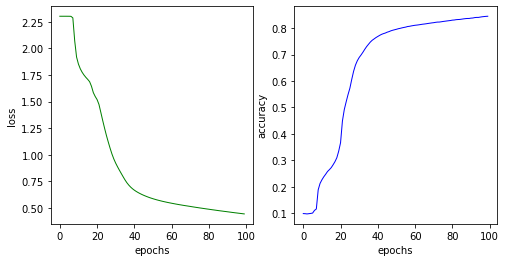

Training on augmented Data...
Epoch 1: Loss = 2.3026, Accuracy = 9.8772
Epoch 10: Loss = 1.7195, Accuracy = 27.5458
Epoch 20: Loss = 0.9122, Accuracy = 67.7987
Epoch 30: Loss = 0.7312, Accuracy = 74.1367
Epoch 40: Loss = 0.6698, Accuracy = 76.1264
Epoch 50: Loss = 0.6261, Accuracy = 77.6298
Epoch 60: Loss = 0.5910, Accuracy = 78.8142
Epoch 70: Loss = 0.5620, Accuracy = 79.9076
Epoch 80: Loss = 0.5375, Accuracy = 80.8479
Epoch 90: Loss = 0.5162, Accuracy = 81.6381
Epoch 100: Loss = 0.4975, Accuracy = 82.2943


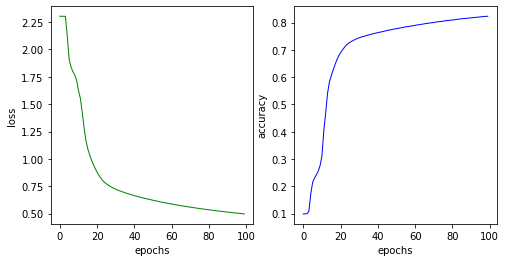

In [56]:
# Shuffle the unaugmented training data
index = np.random.permutation(len(unaugmented_train_data_features))
shuffled_unaugmented_train_data_features, shuffled_unaugmented_train_labels = unaugmented_train_data_features[index], one_hot_encode(unaugmented_train_labels[index],10)
# Shuffle the augmented training data
index = np.random.permutation(len(augmented_train_data_features))
shuffled_augmented_train_data_features, shuffled_augmented_train_labels = augmented_train_data_features[index], one_hot_encode(augmented_train_labels[index],10)

# Create an object for the unaugmented training data
unaugmented_net = Neural_network(shuffled_unaugmented_train_data_features, shuffled_unaugmented_train_labels)

# Create an object for the augmented training data
augmented_net = Neural_network(shuffled_augmented_train_data_features, shuffled_augmented_train_labels)

print('Training on Un-augmented Data...')
unaugmented_net.train(n_epochs=100, batch_size=64, learning_rate=0.01)

# Train the model on augmented data save model parameters
print('Training on augmented Data...')
augmented_net.train(n_epochs=100, batch_size=64, learning_rate=0.01)

## 7)  Implementaion of Various Classification algorithm

In [22]:
# Test both the trained models on test data features
u_accuracy_unaugument_test = unaugmented_net.test(unaugmented_test_data_features, one_hot_encode(unaugmented_test_labels,10))
print('Accuracy of unaugmented test data on unaugmented train data',u_accuracy_unaugument_test*100,'%')

u_accuracy_augument_test = unaugmented_net.test(augmented_test_data_features, one_hot_encode(augmented_test_labels,10))
print('Accuracy of augmented test data on unaugmented train data',u_accuracy_augument_test*100,'%')

a_accuracy_unaugument_test = augmented_net.test(unaugmented_test_data_features,one_hot_encode(unaugmented_test_labels,10))
print('Accuracy of unaugmented test data on augmented train data',a_accuracy_unaugument_test*100,'%')

a_accuracy_augument_test = augmented_net.test(augmented_test_data_features,one_hot_encode(augmented_test_labels,10))
print('Accuracy of augmented test data on augmented train data',a_accuracy_augument_test*100,'%')

Accuracy of unaugmented test data on unaugmented train data 79.5 %
Accuracy of augmented test data on unaugmented train data 71.34 %
Accuracy of unaugmented test data on augmented train data 79.41 %
Accuracy of augmented test data on augmented train data 73.745 %


In [29]:
from sklearn import svm
from sklearn.metrics import accuracy_score
clf = svm.LinearSVC() 

clf.fit(unaugmented_train_data_features,unaugmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
u_accuracy_unaugument_svm = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on unaugmented train data', u_accuracy_unaugument_svm*100,'%')
predictions = clf.predict(augmented_test_data_features)
u_accuracy_augument_svm = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on unaugmented train data', u_accuracy_augument_svm*100,'%')

clf.fit(augmented_train_data_features,augmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
a_accuracy_unaugument_svm = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on augmented train data', a_accuracy_unaugument_svm*100,'%')
predictions = clf.predict(augmented_test_data_features)
a_accuracy_augument_svm = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on augmented train data', a_accuracy_augument_svm*100,'%')

Accuracy of unaugmented test data on unaugmented train data 77.8 %
Accuracy of augmented test data on unaugmented train data 69.985 %
Accuracy of unaugmented test data on augmented train data 75.61 %
Accuracy of augmented test data on augmented train data 69.695 %


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(random_state=42,multi_class='ovr',max_iter = 1000)

clf.fit(unaugmented_train_data_features,unaugmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
u_accuracy_unaugument_lr = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on unaugmented train data', u_accuracy_unaugument_lr*100,'%')
predictions = clf.predict(augmented_test_data_features)
u_accuracy_augument_lr = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on unaugmented train data', u_accuracy_augument_lr*100,'%')

clf.fit(augmented_train_data_features,augmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
a_accuracy_unaugument_lr = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on augmented train data', a_accuracy_unaugument_lr*100,'%')
predictions = clf.predict(augmented_test_data_features)
a_accuracy_augument_lr = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on augmented train data', a_accuracy_augument_lr*100,'%')

Accuracy of unaugmented test data on unaugmented train data 78.86 %
Accuracy of augmented test data on unaugmented train data 71.015 %
Accuracy of unaugmented test data on augmented train data 78.92 %
Accuracy of augmented test data on augmented train data 72.885 %


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
clf = KNeighborsClassifier()

clf.fit(unaugmented_train_data_features,unaugmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
u_accuracy_unaugument_knn = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on unaugmented train data', u_accuracy_unaugument_knn*100,'%')
predictions = clf.predict(augmented_test_data_features)
u_accuracy_augument_knn = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on unaugmented train data', u_accuracy_augument_knn*100,'%')

clf.fit(augmented_train_data_features,augmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
a_accuracy_unaugument_knn = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on augmented train data', a_accuracy_unaugument_knn*100,'%')
predictions = clf.predict(augmented_test_data_features)
a_accuracy_augument_knn = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on augmented train data', a_accuracy_augument_knn*100,'%')

Accuracy of unaugmented test data on unaugmented train data 68.95 %
Accuracy of augmented test data on unaugmented train data 61.970000000000006 %
Accuracy of unaugmented test data on augmented train data 67.55 %
Accuracy of augmented test data on augmented train data 61.99 %


In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier(max_depth =12, random_state = 42)

clf.fit(unaugmented_train_data_features,unaugmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
u_accuracy_unaugument_dt = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on unaugmented train data', u_accuracy_unaugument_dt*100,'%')
predictions = clf.predict(augmented_test_data_features)
u_accuracy_augument_dt = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on unaugmented train data', u_accuracy_augument_dt*100,'%')

clf.fit(augmented_train_data_features,augmented_train_labels)

predictions = clf.predict(unaugmented_test_data_features)
a_accuracy_unaugument_dt = accuracy_score(unaugmented_test_labels, predictions)
print('Accuracy of unaugmented test data on augmented train data', a_accuracy_unaugument_dt*100,'%')
predictions = clf.predict(augmented_test_data_features)
a_accuracy_augument_dt = accuracy_score(augmented_test_labels, predictions)
print('Accuracy of augmented test data on augmented train data', a_accuracy_augument_dt*100,'%')

Accuracy of unaugmented test data on unaugmented train data 48.42 %
Accuracy of augmented test data on unaugmented train data 43.555 %
Accuracy of unaugmented test data on augmented train data 48.9 %
Accuracy of augmented test data on augmented train data 44.61 %


# 8)- The performance of the above four classifier and the following trained MLP models on both the original (unaugmented) test set and augmented test set

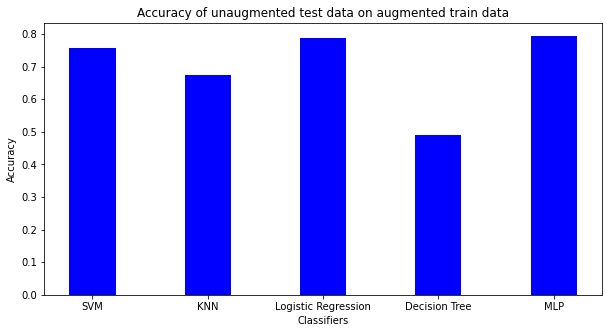

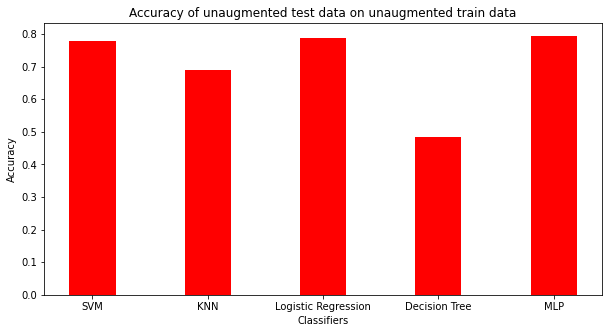

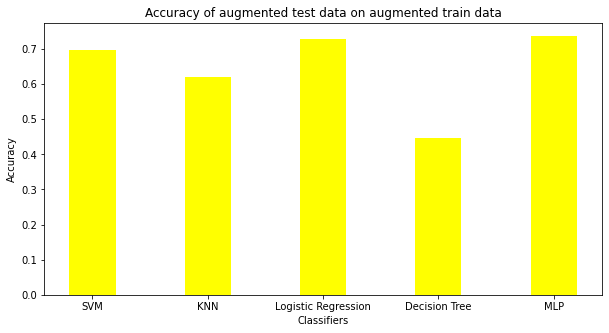

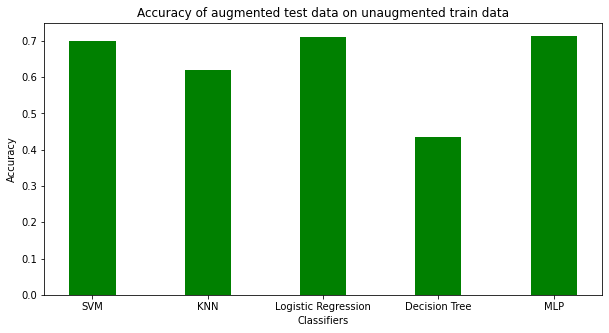

In [38]:
classfiers = ['SVM','KNN','Logistic Regression','Decision Tree','MLP']

Accuracy = [a_accuracy_unaugument_svm,a_accuracy_unaugument_knn,a_accuracy_unaugument_lr,a_accuracy_unaugument_dt,a_accuracy_unaugument_test]
fig = plt.figure(figsize = (10, 5))
plt.bar(classfiers, Accuracy, color ='blue',width = 0.4)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracy of unaugmented test data on augmented train data")
plt.show()


Accuracy = [u_accuracy_unaugument_svm,u_accuracy_unaugument_knn,u_accuracy_unaugument_lr,u_accuracy_unaugument_dt,a_accuracy_unaugument_test]
fig = plt.figure(figsize = (10, 5))
plt.bar(classfiers, Accuracy, color ='red',width = 0.4)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracy of unaugmented test data on unaugmented train data")
plt.show()


Accuracy = [a_accuracy_augument_svm,a_accuracy_augument_knn,a_accuracy_augument_lr,a_accuracy_augument_dt,a_accuracy_augument_test]
fig = plt.figure(figsize = (10, 5))
plt.bar(classfiers, Accuracy, color ='yellow',width = 0.4)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracy of augmented test data on augmented train data")
plt.show()


Accuracy = [u_accuracy_augument_svm,u_accuracy_augument_knn,u_accuracy_augument_lr,u_accuracy_augument_dt,u_accuracy_augument_test]
fig = plt.figure(figsize = (10, 5))
plt.bar(classfiers, Accuracy, color ='green',width = 0.4)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracy of augmented test data on unaugmented train data")
plt.show()
